# NLP With Hotel Review

In [31]:
import pandas as pd
import numpy as np
# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
# libraries for proprocessing 
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
import string
from sklearn.model_selection import train_test_split
# libraries for modelling
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier 
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score

from warnings import filterwarnings
filterwarnings(action='ignore')

In [3]:
# load Hotel Review data
df = pd. read_csv('Hotel_Reviews.csv',index_col =0)
# use 20% of the total Hotel Review data to help future computation
df = df.sample(frac = 0.2)
# view information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103148 entries, 136880 to 95255
Data columns (total 29 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Additional_Number_of_Scoring                103148 non-null  int64  
 1   Average_Score                               103148 non-null  float64
 2   Negative_Review                             103148 non-null  object 
 3   Review_Total_Negative_Word_Counts           103148 non-null  int64  
 4   Total_Number_of_Reviews                     103148 non-null  int64  
 5   Positive_Review                             103148 non-null  object 
 6   Review_Total_Positive_Word_Counts           103148 non-null  int64  
 7   Total_Number_of_Reviews_Reviewer_Has_Given  103148 non-null  int64  
 8   Reviewer_Score                              103148 non-null  int64  
 9   Days_Since_Review                           103148 non-null  int64  
 1

**Data Dictionary**
|Column Name| Description|
|---|---|
|Hotel_Address|Address of hotel|
|Review_Date|Date when reviewer posted the corresponding review|
|Average_Score|Average Score of the hotel, calculated based on the latest comment in the last year|
|Hotel_Name|Name of Hotel|
|Reviewer_Nationality|Nationality of Reviewer|
|Negative_Review|Negative Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Negative'|
|Review_Total_Negative_Word_Counts|Total number of words in the negative review|
|Positive_Review|Positive Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Positive'|
|Review_Total_Positive_Word_Counts|Total number of words in the positive review|
|Reviewer_Score|Score the reviewer has given to the hotel, based on his/her experience|
|Total_Number_of_Reviews_Reviewer_Has_Given|Number of Reviews the reviewers has given in the past|
|Total_Number_of_Reviews|Total number of valid reviews the hotel has|
|Tags|Tags reviewer gave the hotel|
|days_since_review|Duration between the review date and scrape date|
|Additional_Number_of_Scoring|There are also some guests who just made a scoring on the service rather than a review. This number indicates how many valid scores without review in there|
|lat|Latitude of the hotel|
|lng|longtitude of the hotel|

Dictionary Source: https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe

#### Data Information Findings
There are **29 columns** and **103,148 rows** in the random sample of Hotel Review data. Most of the data types are **int64** and **float64** which can be used for potential logistic/linear regression models. The data has already modified the Hotel_Address and Review_Nationality to become dummy variables. The non-null values for all columns match up with the number of data entries meaning that there are no missing values. 

In [4]:
df.describe()

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Days_Since_Review,Latitude,Longitude,...,Reviewer_Nationality_USA,Reviewer_Nationality_Other,Hotel_Address_Amsterdam,Hotel_Address_Barcelona,Hotel_Address_London,Hotel_Address_Milan,Hotel_Address_Paris,Hotel_Address_Vienna,Leisure_Trip,Nights_Stayed
count,103148.000000,103148.000000,103148.000000,103148.000000,103148.000000,103148.000000,103148.000000,103148.000000,103148.000000,103148.000000,...,103148.000000,103148.000000,103148.000000,103148.000000,103148.000000,103148.000000,103148.000000,103148.000000,103148.000000,103148.000000
mean,499.620342,8.396375,18.509210,2748.759879,17.721895,7.093623,0.567224,354.691424,49.429929,2.887220,...,0.069240,0.365543,0.108524,0.116638,0.510635,0.071858,0.116338,0.076007,0.809255,2.355101
std,502.669010,0.547294,29.596307,2325.916693,21.682646,10.950855,0.495463,209.057109,3.458069,4.677097,...,0.253864,0.481584,0.311042,0.320990,0.499889,0.258254,0.320631,0.265011,0.392891,1.632259
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,0.000000,41.328376,-0.369758,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,0.000000,176.000000,48.214066,-0.143649,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,1.000000,354.000000,51.499981,0.019886,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000
75%,666.000000,8.800000,23.000000,3611.000000,22.000000,8.000000,1.000000,528.000000,51.516191,4.834443,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,3.000000
max,2682.000000,9.800000,408.000000,16670.000000,384.000000,355.000000,1.000000,730.000000,52.400181,16.429233,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,30.000000


#### Data Description Findings
The **Average Score** of the Hotel across all locations is **8.4** out of 10. The average word count for negative reviews is greater than the positive reviews. People who leave negative reviews tend to have more words to say about the hotel than if they were to leave a positive review. The **Average Nights Stayed** of the Hotel across all locations is 2.4 days.

In [5]:
# check if there is duplicate data in hotel reviews
total_entries = len(df)
dup_entries = total_entries - len(df.drop_duplicates())
print(f"Count of duplicated data in hotel reviews: {dup_entries}")
print(f"Percentage of duplicated data in hotel reviews: {round(dup_entries/total_entries*100,3)}%")
# Results: there is duplicate data in the hotel reviews that can be dropped given its low impact on future modelling 

Count of duplicated data in hotel reviews: 29
Percentage of duplicated data in hotel reviews: 0.028%


In [6]:
# remove duplicate data
df = df.drop_duplicates(keep=False)
# check that no duplicate data is shown 
new_total_entries = len(df)
new_dup_entries = new_total_entries - len(df.drop_duplicates())
print(f"Updated Count of duplicated data in hotel reviews: {new_dup_entries}")

Updated Count of duplicated data in hotel reviews: 0


## Preprocessing
Split the data into train and test sets and transform the positive and negative review columns using a CountVectorizer. Consider the following:
- What tokenizer and text cleaning steps do you include?
- Using the vectorizer, maximize the number of features at 500 and make sure that tokens used <10 times are dropped from the vocabulary.

This process may be done on the positive and negative review columns separately and then the resulting arrays merged with the original numeric features to form the final train and test data frames ready for modelling. In your column names, make sure you mark which words are coming from the positive vs negative reviews (you can use a prefix such as pos_ and neg_).

--- 

In [11]:
# clean data
forbidden_char = string.punctuation + "1234567890"

def custom_tokenizer(text):
    """
    Custom tokenizer function.

    Outputs: list of tokens, list of tokens (list of strings), the clean and processing document
    """
    # lower text
    text = text.lower()

    # remove special characters
    text = re.sub(f"[{forbidden_char}]", "", text)

    # split into words as tokens
    tokens = text.split()

    # filter stopwords
    tokens = [tok for tok in tokens if tok not in ENGLISH_STOP_WORDS]

    return tokens

In [12]:
# Split the data into train and test sets
X = df[["Positive_Review","Negative_Review"]]
y= df["Reviewer_Score"] 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

# check shapes of train and test set 
print(f"Shape of X_train set: {X_train.shape}")
print(f"Shape of y_train set: {y_train.shape}")
print(f"Shape of X_test set: {X_test.shape}")
print(f"Shape of y_test set: {y_test.shape}")

Shape of X_train set: (77317, 2)
Shape of y_train set: (77317,)
Shape of X_test set: (25773, 2)
Shape of y_test set: (25773,)


In [13]:
# Instantiate and fit CountVectorizer to positive and negative review columns in TRAIN set
vec_pos = CountVectorizer(tokenizer=custom_tokenizer,min_df=10,max_features=500,token_pattern=None) 
vec_pos.fit(X_train["Positive_Review"])
vec_neg = CountVectorizer(tokenizer=custom_tokenizer,min_df=10,max_features=500,token_pattern=None) 
vec_neg.fit(X_train["Negative_Review"])

# Transform positive and negative review columns in TRAIN set
X_train_transformed_pos = vec_pos.transform(X_train["Positive_Review"])
X_train_transformed_neg = vec_neg.transform(X_train["Negative_Review"])

# add prefix to columns (pos_ , neg_)
columns_pos = vec_pos.get_feature_names_out()
columns_neg = vec_neg.get_feature_names_out()

for i in range(len(columns_pos)):
    columns_pos[i] = "pos_" + columns_pos[i]

for i in range(len(columns_neg)):
    columns_neg[i] = "neg_" + columns_neg[i]

# create dataframes for positive and negative reviews on training set
# data: Converted sparse matrix into a numpy array
# columns: tokens
vec_df_pos_train = pd.DataFrame(
    data=X_train_transformed_pos.toarray(),
    columns=columns_pos) 

vec_df_neg_train = pd.DataFrame(
    data=X_train_transformed_neg.toarray(),
    columns=columns_neg)

In [14]:
# Transform positive and negative review columns in TEST set
X_test_transformed_pos = vec_pos.transform(X_test["Positive_Review"])
X_test_transformed_neg = vec_neg.transform(X_test["Negative_Review"])

# create dataframes for positive and negative reviews on TEST set
# data: Converted sparse matrix into a numpy array
# columns: tokens
vec_df_pos_test = pd.DataFrame(
    data=X_test_transformed_pos.toarray(),
    columns=columns_pos) 

vec_df_neg_test = pd.DataFrame(
    data=X_test_transformed_neg.toarray(),
    columns=columns_neg)

# check shape of train and test dataframes for positive/negative reviews
print(f"Shape of transformed positive train set: {vec_df_pos_train.shape}")
print(f"Shape of transformed negative train set: {vec_df_neg_train.shape}")
print(f"Shape of transformed positive test set: {vec_df_pos_test.shape}")
print(f"Shape of transformed negative test set: {vec_df_neg_test.shape}")


Shape of transformed positive train set: (77317, 500)
Shape of transformed negative train set: (77317, 500)
Shape of transformed positive test set: (25773, 500)
Shape of transformed negative test set: (25773, 500)


In [15]:
# merge positive and negative transformations 
# combine: positive training + negative training
X_train_transformed = pd.concat([vec_df_pos_train, vec_df_neg_train], axis=1)
# combine: positive test + negative test
X_test_transformed = pd.concat([vec_df_pos_test, vec_df_neg_test], axis=1)

# check merged dataframes
print(f"Shape of transformed train set: {X_train_transformed.shape}")
print(f"Shape of transformed test set: {X_test_transformed.shape}")

Shape of transformed train set: (77317, 1000)
Shape of transformed test set: (25773, 1000)


--- 

## Modelling

Fit a logistic regression model on the data and analyze the test and train accuracy. Find the top 20 words from the positive reviews that are most predictive of a positive sentiment (Reviewer_Score = 1). Similarly, find the top 20 words from the negative reviews that are most predictive of a negative sentiment (Reviewer_Score = 0). What actionable insights can you draw from these?

--- 

In [16]:
# Fit a logistic regression model on the transformed positive data
logreg_pos = LogisticRegression(max_iter=1000).fit(vec_df_pos_train, y_train) 

# predict on positive train and test set
y_train_pred_pos = logreg_pos.predict(vec_df_pos_train)
y_test_pred_pos = logreg_pos.predict(vec_df_pos_test)

# calculate accuracy score on positive train and test set
train_acc_pos = accuracy_score(y_train, y_train_pred_pos)
test_acc_pos = accuracy_score(y_test, y_test_pred_pos)

# print accuracy score on positive train and test set
print(f"Accuracy Score on Positive Train Set: {round(train_acc_pos,5)}")
print(f"Accuracy Score on Positive Test Set: {round(test_acc_pos,5)}")

Accuracy Score on Positive Train Set: 0.69818
Accuracy Score on Positive Test Set: 0.69464


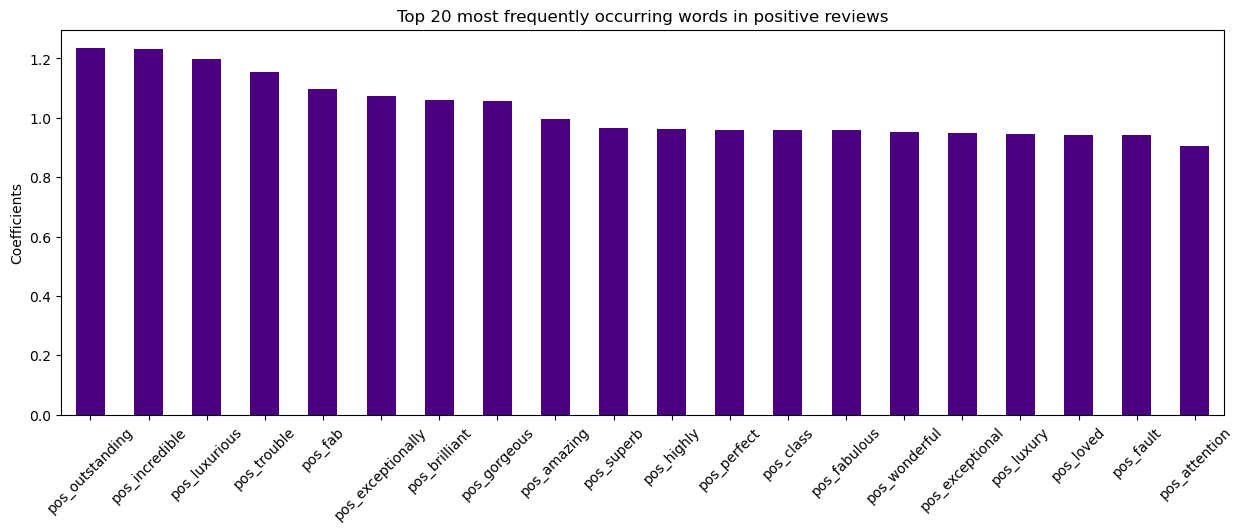

In [17]:
# Find the top 20 words from the positive reviews that are most predictive of a positive sentiment (Reviewer_Score = 1)
pos_coef = logreg_pos.coef_[0] # the first column of coefficients is for predicting 'positive'
word_count_pos = pd.Series(pos_coef,index=columns_pos) 
word_count_pos = word_count_pos.sort_values(ascending=False) # sort from high-to-low

# Display bar plot of the top 20 words from the positive reviews
word_count_pos.head(20).plot(kind="bar", figsize=(15, 5), legend=False,color="indigo")
plt.title("Top 20 most frequently occurring words in positive reviews")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

In [18]:
# Fit a logistic regression model on the transformed negative data
logreg_neg = LogisticRegression(max_iter=1000).fit(vec_df_neg_train, y_train) 

# predict on negative train and test set
y_train_pred_neg = logreg_neg.predict(vec_df_neg_train)
y_test_pred_neg = logreg_neg.predict(vec_df_neg_test)

# calculate accuracy score on negative train and test set
train_acc_neg = accuracy_score(y_train, y_train_pred_neg)
test_acc_neg = accuracy_score(y_test, y_test_pred_neg)
# print accuracy score on negative train and test set
print(f"Accuracy Score on Negative Train Set: {round(train_acc_neg,5)}")
print(f"Accuracy Score on Negative Test Set: {round(test_acc_neg,5)}")

Accuracy Score on Negative Train Set: 0.73882
Accuracy Score on Negative Test Set: 0.72925


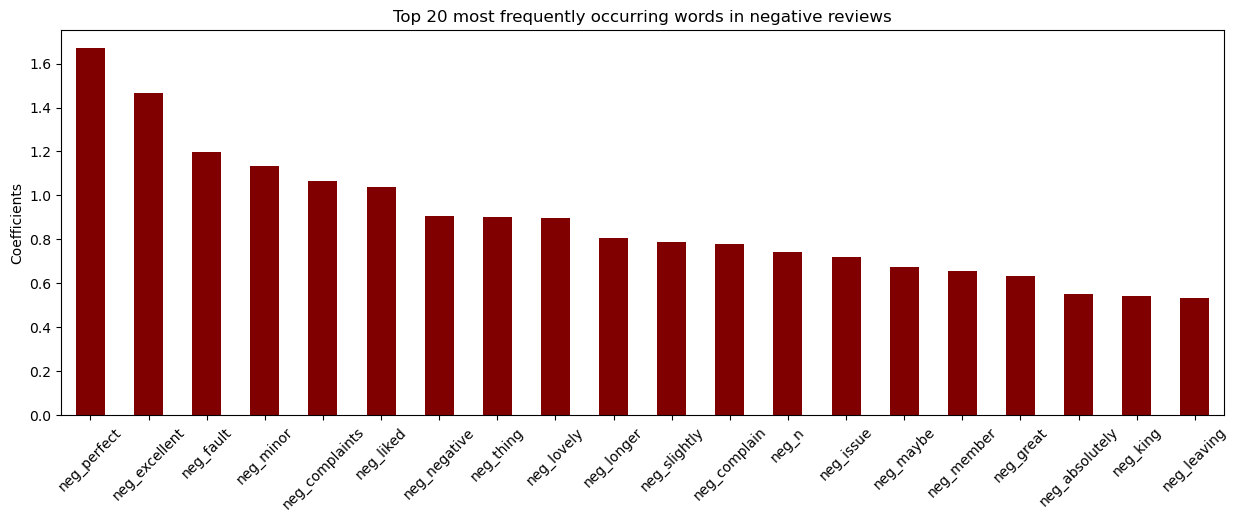

In [19]:
# find the top 20 words from the negative reviews that are most predictive of a negative sentiment (Reviewer_Score = 0)
neg_coef = logreg_neg.coef_[0] # the first column of coefficients is for predicting 'negative'
word_count_neg = pd.Series(neg_coef,index=columns_neg) 
word_count_neg = word_count_neg.sort_values(ascending=False) # sort from high-to-low

# Display bar plot of the top 20 words from the negative reviews
word_count_neg.head(20).plot(kind="bar", figsize=(15, 5), legend=False,color="maroon")
plt.title("Top 20 most frequently occurring words in negative reviews")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

**Actionable Insights from Logistic Regression**

From Positive Reviews
- Words such as "pos_comfort","pos_luxurious",and "pos_class" suggest that customers value high quality in their hotel experience. Customers like to feel pampered in their hotel.
- Words such as "pos_attention","pos_brilliant",and "pos_exceptionally" suggest that customers felt that the hotel service was above their expectations. Customers want service in things they would not have considered but find value in it. An example is giving free toiletries in items not found in other hotels. 

From Negative Reviews
- Words such as "complain","issue",and "fault" suggest irritation and disappointment in hotel's customer service or quality.  
- Words such as "slightly","minor",and "fine" suggest that customers felt that the hotel service was below their expectations. The hotel's service need to address quality concerns. 